#  MODIS Water Data Plotting

Version: 0.0.0

Date Created: 11.13.2023
Created by: Amanda Burke

Date Modified: 
Modified by: Amanda Burke

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from pathlib import Path   
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [28]:
# GPU = False
# MODEL = 'rf'
# TEST_RATIO = 0.2
# RANDOM_STATE = 42
# LABEL_NAME = 'water'
# DATA_TYPE = np.int16
# FRAC_LAND=0.5
# num_datapoints = 10000000

In [29]:
def load_cpu_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
    dataType=np.int16, cpu=True, splitXY=True, trainTestSplit=True,
    applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
    multisample=1000000):
    
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]

    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=testSize)
    else:
        return X, y

In [30]:
colsToDrop = [
    'sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1',
    'sur_refl_b06_1','ndwi1','ndwi2'
    ]

#############################
# VERSION 4.2.1 (targeted 500k points)
v421_TILE_IN = 'Golden'#v4.2.1
v421_DATA_VERSION='v4.2.1'
v421_offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
v421_colsToDrop = colsToDrop.copy()
#Only want to plot sfc band 1
# v421_colsToDrop.extend(['sur_refl_b02_1','sur_refl_b07_1','ndvi'])
#############################

##############################
#VERSION 2.0.1 (5 million points)
v201_TILE_IN = 'GLOBAL'
v201_DATA_VERSION='v2.0.1'
v201_offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day']
v201_colsToDrop = colsToDrop.copy()
##############################

#############################
#VERSION 0.0.0 (2billion data points)
v000_TILE_IN = 'cleaned'
v000_DATA_VERSION='AGU'
v000_offsets_indexes = []
v000_colsToDrop = colsToDrop.copy()
#Only want to plot sfc band 1
# v000_colsToDrop.extend(['sur_refl_b02_1','sur_refl_b07_1','ndvi'])
##############################


TILEs = [v421_TILE_IN,v201_TILE_IN] #,v000_TILE_IN]
DATA_VERSIONs = [v421_DATA_VERSION,v201_DATA_VERSION]# ,v000_DATA_VERSION]
OFFSET_INDs = [v421_offsets_indexes,v201_offsets_indexes]#,v000_offsets_indexes]
COLs = [v421_colsToDrop,v201_colsToDrop]#,v000_colsToDrop]

In [31]:
all_datasets = {}


for d,data_name in enumerate(['v421','v201']): #,'v000']):
    print(data_name)

    training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSIONs[d]}'
    glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILEs[d]))
    data_paths = sorted([fv for fv in glob.glob(glob_string)])
    data_path = data_paths[0]
    print(data_path)

    colsToDropTraining =  COLs[d]
    colsToDropTraining.extend(OFFSET_INDs[d])
    v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
               'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
               'sur_refl_b07_1','ndvi','ndwi1','ndwi2']
    print(colsToDropTraining)
    
    X, X_test, y, y_test = load_cpu_data(fpath=data_path,colsToDrop=colsToDropTraining)
    print(f'data shape: X {X.shape}, y {y.shape}')
    print('\n\n')
    
    if 'v201' in data_name:
        v201_x, v201_y = X,y
    all_datasets[data_name] = X

v421
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.1/MOD09_Golden_Masked_986161_4_2_1.parquet.gzip
['sur_refl_b03_1', 'sur_refl_b04_1', 'sur_refl_b05_1', 'sur_refl_b06_1', 'ndwi1', 'ndwi2', 'x_offset', 'y_offset', 'year', 'julian_day', 'tileID']
data shape: X (788928, 4), y (788928,)



v201
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip
['sur_refl_b03_1', 'sur_refl_b04_1', 'sur_refl_b05_1', 'sur_refl_b06_1', 'ndwi1', 'ndwi2', 'x_offset', 'y_offset', 'year', 'julian_day']
data shape: X (4375821, 4), y (4375821,)





In [32]:
v201_x

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b07_1,ndvi
5131227,842,2589,804,5091
490231,1,-6,-2,14000
4581965,2200,4637,1043,3564
1128050,122,-26,346,-15416
1595511,1350,1720,1618,1205
...,...,...,...,...
4214228,-67,0,9,-10000
726929,602,3471,1403,7043
1398220,34,50,257,1904
3206432,475,2970,800,7242


## Clustering v201 Data

In [33]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind = np.where(v201_y>0.5)[0]
y_land_ind = np.where(v201_y<0.5)[0]

#Subset the X AND y data to later/ subset with the clusters and then combine for RFA
X_water = v201_x.iloc[y_water_ind,:]
y_water = v201_y.iloc[y_water_ind]

X_land = v201_x.iloc[y_land_ind,:]
y_land = v201_y.iloc[y_land_ind]

In [34]:
_ = [print(column) for column in v201_x.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b07_1
ndvi


In [35]:
CLUSTER_NUM=15

common_params = {
    "n_init": "auto",
    "random_state": 42,
    "init":"random"
}

In [36]:
%%time
kmeans_land =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit_predict(X_land)
kmeans_water = KMeans(n_clusters=CLUSTER_NUM, **common_params).fit_predict(X_water)

CPU times: user 10min 13s, sys: 42.5 s, total: 10min 55s
Wall time: 17.3 s


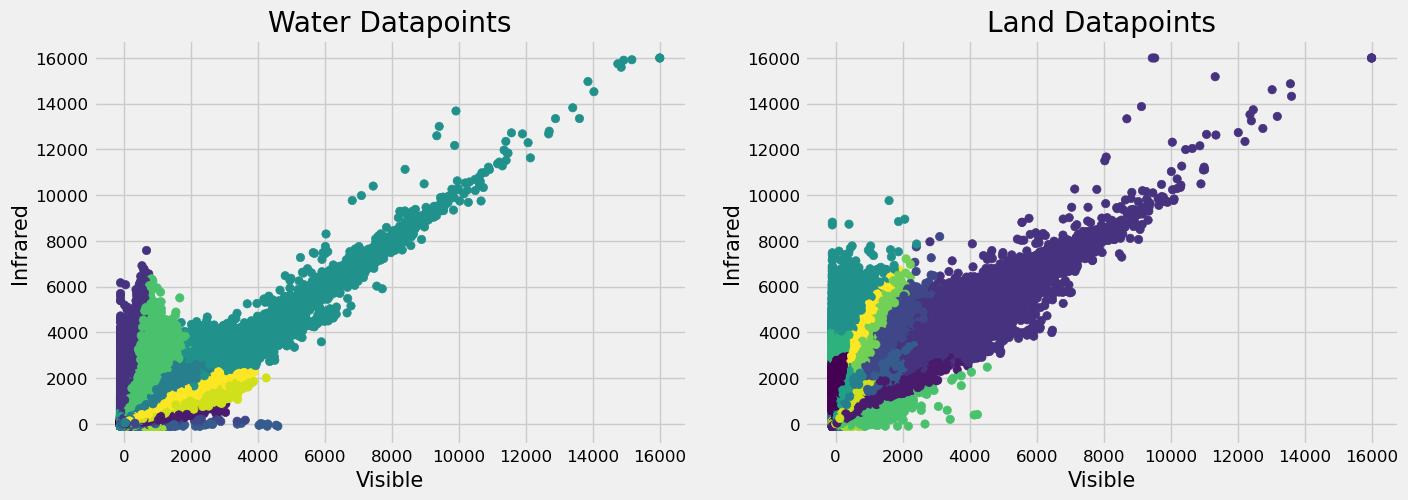

In [45]:
fig, ax =  plt.subplots(1, 2,figsize=(15, 5))


tick_size = 12
ax[0].tick_params(axis='both', which='major', labelsize=tick_size)
ax[0].scatter(X_water['sur_refl_b01_1'],X_water['sur_refl_b02_1'],c=kmeans_water)#,cmap='PuRd')
ax[0].set_title("Water Datapoints")
ax[0].set_xlabel('Visible',size=label_s)
ax[0].set_ylabel('Infrared',size=label_s)

ax[1].tick_params(axis='both', which='major', labelsize=tick_size)
ax[1].scatter(X_land['sur_refl_b01_1'],X_land['sur_refl_b02_1'],c=kmeans_land) #,cmap='PuRd')
ax[1].set_title("Land Datapoints")
ax[1].set_xlabel('Visible',size=label_s)
ax[1].set_ylabel('Infrared',size=label_s)

plt.show()

In [ ]:
land_eb_count = np.inf
water_eb_count = np.inf

for cluster in np.unique(kmeans_land):
    land_num = len(np.where(kmeans_land == cluster)[0])
    if land_num < land_eb_count: 
        land_eb_count = land_num
    water_num = len(np.where(kmeans_water == cluster)[0])
    if water_num < water_eb_count: 
        water_eb_count = water_num
    
if water_eb_count > land_eb_count:
    COUNT = land_eb_count
else: 
    COUNT = water_eb_count
    
print('Chosen count',COUNT,', land',land_eb_count,', water',water_eb_count)

In [ ]:

np.random.seed(42)
total_clus_land = np.array([])
total_clus_water = np.array([])

for cluster in np.unique(kmeans_water):
    print(f'cluster {cluster}')
    #Get the index of given cluster 
    water_idx = np.where(kmeans_water == cluster)[0]
    #Randomly pull the count derived above from that cluster
    clus_water = np.random.choice(water_idx,COUNT,replace=False)
    # if the max values of water in a cluster is less than 10000, keep the cluster
    max_vis_water= np.nanmax(X_water['sur_refl_b01_1'].iloc[water_idx])
    if max_vis_water < 10000:
        total_clus_water  = np.append(total_clus_water, clus_water)
    else: 
        print(f'Cluster {cluster} contains outliers. Max: {max_vis_water}')
    #Get the land random selected cluster points
    land_idx = np.where(kmeans_land == cluster)[0]
    clus_land = np.random.choice(land_idx,COUNT,replace=False)
    total_clus_land = np.append(total_clus_land, clus_land)
    
total_clus_water = total_clus_water.astype('int')
total_clus_land = total_clus_land.astype('int')

print()
print(f'Cluster, length: {len(total_clus_water)}, \n {total_clus_water},{total_clus_land}')

In [ ]:
#############
#Getting the random subset same size as the clustered data
total_match_land = np.random.choice(
    np.arange(len(X_land)),len(total_clus_land),replace=False).astype('int')
total_match_water = np.random.choice(
    np.arange(len(X_water)),len(total_clus_water),replace=False).astype('int')

print(f'Random, length: {len(total_match_water)},\n {total_match_water},{total_match_land}')



In [ ]:
# #Combine the land and water datapoints for the two types of datasets
# #clustered specifically and random subset

#clustered data
X_clus_land = X_land.iloc[total_clus_land]
X_clus_water = X_water.iloc[total_clus_water]
X_clus = pd.concat([X_clus_land,X_clus_water])

#random subsample
X_match_land = X_land.iloc[total_match_land]
X_match_water = X_water.iloc[total_match_water]
X_match = pd.concat([X_match_land,X_match_water])

In [ ]:
print(X_clus)

In [ ]:
print(X_match)

## Plotting Histogram of all MW RFA Data

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(10, 5))
# ax.hist(
#     [ 
#         all_datasets['v201'],
#         all_datasets['v421'],
#         # all_datasets['v000'],
#         X_clus,
#         X_match,
        
#     ],
#     label=[
#         'All',
#         'Expert Selected',
#         # 'v0.0.0',
#         'Clustered',
#         'Random Subset'
#     ],
#     color=[
#         'black',
#         'goldenrod',
#         # 'brown',
#         'plum',
#         'darkorchid'
#     ], 
#     log=True
#     ) 
# ax.legend(loc='upper right',fontsize=15)
# plt.title('Training Data')
# plt.ylabel('Frequency',size=15) 
# plt.xlabel('Visible Reflectance',size=15)
# plt.show()

In [ ]:
 all_datasets


In [ ]:
fig, ax = plt.subplots(2, 2,figsize=(20, 10))
var=0
for col in range(2):
    for row in range(2):
        ax[col, row].set_ylabel('Frequency') 
        variable=all_datasets['v201'].columns[var]
        if 'ndvi' in variable: 
            # var_bins = bin_boundaries
            log_values = False
        else: 
            # var_bins = None
            log_values = True
        ax[row, col].hist(
            [ 
                all_datasets['v201'][variable],
                all_datasets['v421'][variable],
                # all_datasets['v000'],
                X_clus[variable],
                X_match[variable],
            ],
            label=[
                'All',
                'Expert Selected',
                'Cluster',
                'Random Subset'
            ],
            color=[
                'black',
                'goldenrod',
                'plum',
                'darkorchid'
            ], log=log_values
        ) 
        ax[row, col].set_xlabel(f'{variable}')
        var+=1
    ax[0,0].legend(loc='upper right',fontsize=20)
plt.show()
    
    
